In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

VER=4
#model_name = "/kaggle/input/huggingfacedebertav3variants/deberta-v3-xsmall"
#model_name = '/kaggle/input/huggingfacedebertav3variants/deberta-v3-small'
#model_name = '/kaggle/input/huggingfacedebertav3variants/deberta-v3-base'
model_name = 'deberta-v3-large'
EPOCHS = 4

DIR = f"ver_{VER}"
os.makedirs(DIR, exist_ok=True)

In [2]:
import pandas as pd, numpy as np
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train = pd.read_csv('train.csv')
train.Misconception = train.Misconception.fillna('NA')
train['target'] = train.Category+":"+train.Misconception
train['label'] = le.fit_transform(train['target'])
n_classes = len(le.classes_)

import re

# Enhanced feature extraction
train['explanation_len'] = train['StudentExplanation'].fillna('').apply(len)
train['mc_frac_count'] = train['StudentExplanation'].fillna('').apply(
    lambda x: len(re.findall(r'FRAC_\d+_\d+|\\frac', x))
)
train['number_count'] = train['StudentExplanation'].fillna('').apply(
    lambda x: len(re.findall(r'\b\d+\b', x))
)
train['operator_count'] = train['StudentExplanation'].fillna('').apply(
    lambda x: len(re.findall(r'[\+\-\*/=]', x))
)
train['mc_answer_len'] = train['MC_Answer'].fillna('').apply(len)
train['question_len'] = train['QuestionText'].fillna('').apply(len)
train['explanation_to_question_ratio'] = train['explanation_len'] / (train['question_len'] + 1)

print(f"Train shape: {train.shape} with {n_classes} target classes")

train.head()

Train shape: (36696, 16) with 65 target classes


,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Category,Misconception,target,label,explanation_len,mc_frac_count,number_count,operator_count,mc_answer_len,question_len,explanation_to_question_ratio
0,0,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),0ne third is equal to tree nineth,True_Correct,NA,True_Correct:NA,37,33,0,0,0,17,160,0.204969
1,1,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 / 3 because 6 over 9 is 2 thirds and 1 third...,True_Correct,NA,True_Correct:NA,37,61,0,6,1,17,160,0.378882
2,2,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"1 3rd is half of 3 6th, so it is simplee to un...",True_Neither,NA,True_Neither:NA,64,55,0,2,0,17,160,0.341615
3,3,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 goes into everything and 3 goes into nine,True_Neither,NA,True_Neither:NA,64,43,0,2,0,17,160,0.267081
4,4,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 out of every 3 isn't coloured,True_Correct,NA,True_Correct:NA,37,31,0,2,0,17,160,0.192547


In [3]:
idx = train.apply(lambda row: row.Category.split('_')[0],axis=1)=='True'
correct = train.loc[idx].copy()
correct['c'] = correct.groupby(['QuestionId','MC_Answer']).MC_Answer.transform('count')
correct = correct.sort_values('c',ascending=False)
correct = correct.drop_duplicates(['QuestionId'])
correct = correct[['QuestionId','MC_Answer']]
correct['is_correct'] = 1

train = train.merge(correct, on=['QuestionId','MC_Answer'], how='left')
train.is_correct = train.is_correct.fillna(0)

In [4]:
from IPython.display import display, Math, Latex

# GET ANSWER CHOICES
tmp = train.groupby(['QuestionId','MC_Answer']).size().reset_index(name='count')
tmp['rank'] = tmp.groupby('QuestionId')['count'].rank(method='dense', ascending=False).astype(int) - 1
tmp = tmp.drop('count',axis=1)
tmp = tmp.sort_values(['QuestionId','rank'])

# DISPLAY QUESTION AND ANSWER CHOICES
Q = tmp.QuestionId.unique()
for q in Q:
    question = train.loc[train.QuestionId==q].iloc[0].QuestionText
    choices = tmp.loc[tmp.QuestionId==q].MC_Answer.values
    labels="ABCD"
    choice_str = " ".join([f"({labels[i]}) {choice}" for i, choice in enumerate(choices)])
    
    print()
    display(Latex(f"QuestionId {q}: {question}") )
    display(Latex(f"MC Answers: {choice_str}"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [5]:
print(model_name)

deberta-v3-large


In [6]:
import torch
from transformers import DebertaTokenizer, DebertaForSequenceClassification, TrainingArguments, Trainer
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from datasets import Dataset
import numpy as np
model_name = 'deberta-v3-large'
tokenizer = AutoTokenizer.from_pretrained(model_name)
MAX_LEN = 256

/home/suzumiyaharuhi/anaconda3/envs/map/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [7]:
def format_input(row):
    x = "This answer is correct."
    if not row['is_correct']:
        x = "This answer is incorrect."

    extra = (
        f"Additional Info: "
        f"The explanation has {row['explanation_len']} characters "
        f"and includes {row['mc_frac_count']} fraction(s)."
    )

    return (
        f"Question: {row['QuestionText']}\n"
        f"Answer: {row['MC_Answer']}\n"
        f"{x}\n"
        f"Student Explanation: {row['StudentExplanation']}\n"
        f"{extra}"
    )

train['text'] = train.apply(format_input,axis=1)
print("Example prompt for our LLM:")
print()
print( train.text.values[0] )

Example prompt for our LLM:

Question: What fraction of the shape is not shaded? Give your answer in its simplest form. [Image: A triangle split into 9 equal smaller triangles. 6 of them are shaded.]
Answer: \( \frac{1}{3} \)
This answer is correct.
Student Explanation: 0ne third is equal to tree nineth
Additional Info: The explanation has 33 characters and includes 0 fraction(s).


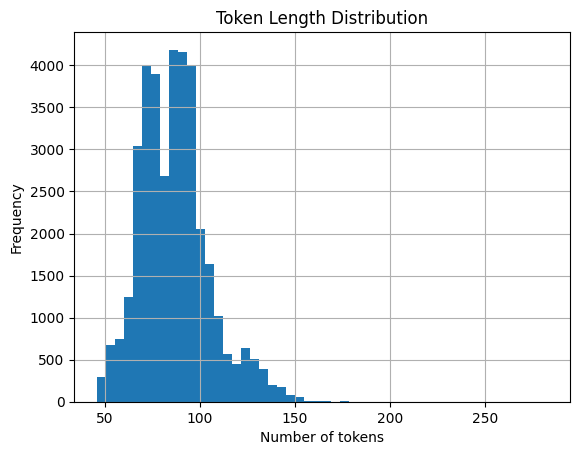

In [8]:
lengths = [len(tokenizer.encode(t, truncation=False)) for t in train["text"]]
import matplotlib.pyplot as plt

plt.hist(lengths, bins=50)
plt.title("Token Length Distribution")
plt.xlabel("Number of tokens")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [9]:
L = (np.array(lengths)>MAX_LEN).sum()
print(f"There are {L} train sample(s) with more than {MAX_LEN} tokens")
np.sort( lengths )

There are 1 train sample(s) with more than 256 tokens


array([ 46,  46,  46, ..., 200, 247, 283])

In [10]:
# Split into train and validation sets
train_df, val_df = train_test_split(train, test_size=0.05, random_state=42)

# Convert to Hugging Face Dataset
COLS = ['text','label']
train_ds = Dataset.from_pandas(train_df[COLS])
val_ds = Dataset.from_pandas(val_df[COLS])

In [11]:
# Tokenization function
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)

train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)

# Set format for PyTorch
columns = ['input_ids', 'attention_mask', 'label']
train_ds.set_format(type='torch', columns=columns)
val_ds.set_format(type='torch', columns=columns)

Map:   0%|          | 0/34861 [00:00<?, ? examples/s]

Map:   0%|          | 0/1835 [00:00<?, ? examples/s]

In [12]:
from transformers import DebertaV2ForSequenceClassification

model = DebertaV2ForSequenceClassification.from_pretrained(
    model_name,
    num_labels=n_classes,
    ignore_mismatched_sizes=True #与从github上直接下载的baseline1有不同
)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at deberta-v3-large and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([65]) in the model instantiated
- classifier.weight: found shape torch.Size([2, 1024]) in the checkpoint and torch.Size([65, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# training_args = TrainingArguments(
#     output_dir = f"./{DIR}",
#     do_train=True,
#     do_eval=True,
#     eval_strategy="steps",
#     save_strategy="steps", #no for no saving 
#     num_train_epochs=EPOCHS,
#     per_device_train_batch_size=16*2,
#     per_device_eval_batch_size=32*2,
#     learning_rate=5e-5,
#     logging_dir="./logs",
#     logging_steps=50,
#     save_steps=200,
#     eval_steps=200,
#     save_total_limit=1,
#     metric_for_best_model="map@3",
#     greater_is_better=True,
#     load_best_model_at_end=True,
#     report_to="none",
# )



training_args = TrainingArguments(
    output_dir=f"./{DIR}",
    do_train=True,
    do_eval=True,
    eval_strategy="steps",
    save_strategy="steps",
    num_train_epochs=EPOCHS,

    # Keep batch size small for memory
    per_device_train_batch_size=1,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=16,  # Simulates batch_size * 4


    # Must enable mixed precision to reduce VRAM usage
    fp16=True,

    optim='adamw_8bit',

    learning_rate=1e-5,#5e-5
    warmup_ratio=0.1,
    lr_scheduler_type='cosine',
    logging_dir="./logs",
    logging_steps=50,
    save_steps=200,
    eval_steps=200,
    save_total_limit=1,
    metric_for_best_model="map@3",
    greater_is_better=True,
    load_best_model_at_end=True,
    report_to="none",
)

In [14]:
# CUSTOM MAP@3 METRIC

from sklearn.metrics import average_precision_score

def compute_map3(eval_pred):
    logits, labels = eval_pred
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()
    
    top3 = np.argsort(-probs, axis=1)[:, :3]  # Top 3 predictions
    match = (top3 == labels[:, None])

    # Compute MAP@3 manually
    map3 = 0
    for i in range(len(labels)):
        if match[i, 0]:
            map3 += 1.0
        elif match[i, 1]:
            map3 += 1.0 / 2
        elif match[i, 2]:
            map3 += 1.0 / 3
    return {"map@3": map3 / len(labels)}

In [15]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_map3,
)

trainer.train()

/tmp/ipykernel_1139402/2123443610.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Map@3
200,2.874000,2.480013,0.529337
400,1.629800,1.498755,0.689827
600,1.107100,1.193906,0.774114
800,0.985700,0.987084,0.798183
1000,0.912000,0.828832,0.843778
1200,0.740300,0.723904,0.861762
1400,0.633900,0.710359,0.866122
1600,0.598300,0.659221,0.878020
1800,0.610200,0.607916,0.880654
2000,0.556200,0.584171,0.896276


TrainOutput(global_step=8716, training_loss=0.5380335614297191, metrics={'train_runtime': 15366.9923, 'train_samples_per_second': 9.074, 'train_steps_per_second': 0.567, 'total_flos': 6.499038822676685e+16, 'train_loss': 0.5380335614297191, 'epoch': 4.0})

In [16]:
import joblib

trainer.save_model(f"{DIR}/best")
_ = joblib.dump(le, f"{DIR}/label_encoder.joblib")

In [17]:
tokenizer = AutoTokenizer.from_pretrained(f"{DIR}/best")
model = DebertaV2ForSequenceClassification.from_pretrained(
    f"{DIR}/best",
    num_labels=n_classes  
)
training_args = TrainingArguments(report_to="none")
trainer = Trainer(model=model, tokenizer=tokenizer, args=training_args)
le = joblib.load(f"{DIR}/label_encoder.joblib")

/tmp/ipykernel_1139402/3737802152.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer, args=training_args)


In [18]:
test = pd.read_csv('test.csv')
print( test.shape )
test.head()

(3, 5)


,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation
0,36696,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"I think that 1/3 is the answer, as it's the si..."
1,36697,31772,What fraction of the shape is not shaded? Give...,\( \frac{3}{6} \),i think this answer is because 3 triangles are...
2,36698,32835,Which number is the greatest?,\( 6.2 \),because the 2 makes it higher than the others.


In [19]:
import re

# Enhanced feature extraction for test set
test['explanation_len'] = test['StudentExplanation'].fillna('').apply(len)
test['mc_frac_count'] = test['StudentExplanation'].fillna('').apply(
    lambda x: len(re.findall(r'FRAC_\d+_\d+|\\frac', x))
)
test['number_count'] = test['StudentExplanation'].fillna('').apply(
    lambda x: len(re.findall(r'\b\d+\b', x))
)
test['operator_count'] = test['StudentExplanation'].fillna('').apply(
    lambda x: len(re.findall(r'[\+\-\*/=]', x))
)
test['mc_answer_len'] = test['MC_Answer'].fillna('').apply(len)
test['question_len'] = test['QuestionText'].fillna('').apply(len)
test['explanation_to_question_ratio'] = test['explanation_len'] / (test['question_len'] + 1)


In [20]:
test.head()

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,explanation_len,mc_frac_count,number_count,operator_count,mc_answer_len,question_len,explanation_to_question_ratio
0,36696,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"I think that 1/3 is the answer, as it's the si...",65,0,4,2,17,160,0.403727
1,36697,31772,What fraction of the shape is not shaded? Give...,\( \frac{3}{6} \),i think this answer is because 3 triangles are...,77,0,2,0,17,160,0.478261
2,36698,32835,Which number is the greatest?,\( 6.2 \),because the 2 makes it higher than the others.,46,0,1,0,9,29,1.533333


In [21]:
test = test.merge(correct, on=['QuestionId','MC_Answer'], how='left')
test.is_correct = test.is_correct.fillna(0)



test['text'] = test.apply(format_input,axis=1)

test.head()

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,explanation_len,mc_frac_count,number_count,operator_count,mc_answer_len,question_len,explanation_to_question_ratio,is_correct,text
0,36696,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"I think that 1/3 is the answer, as it's the si...",65,0,4,2,17,160,0.403727,1.0,Question: What fraction of the shape is not sh...
1,36697,31772,What fraction of the shape is not shaded? Give...,\( \frac{3}{6} \),i think this answer is because 3 triangles are...,77,0,2,0,17,160,0.478261,0.0,Question: What fraction of the shape is not sh...
2,36698,32835,Which number is the greatest?,\( 6.2 \),because the 2 makes it higher than the others.,46,0,1,0,9,29,1.533333,1.0,Question: Which number is the greatest?\nAnswe...


In [22]:
ds_test = Dataset.from_pandas(test[['text']])
ds_test = ds_test.map(tokenize, batched=True)

predictions = trainer.predict(ds_test)
probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

In [23]:
# Get top 3 predicted class indices
top3 = np.argsort(-probs, axis=1)[:, :3]   # shape: [num_samples, 3]

# Decode numeric class indices to original string labels
flat_top3 = top3.flatten()
decoded_labels = le.inverse_transform(flat_top3)
top3_labels = decoded_labels.reshape(top3.shape)

# Join 3 labels per row with space
joined_preds = [" ".join(row) for row in top3_labels]

# Save submission
sub = pd.DataFrame({
    "row_id": test.row_id.values,
    "Category:Misconception": joined_preds
})
sub.to_csv("submission.csv", index=False)
sub.head()

,row_id,Category:Misconception
0,36696,True_Correct:NA True_Neither:NA False_Correct:NA
1,36697,False_Misconception:WNB False_Neither:NA False...
2,36698,True_Neither:NA True_Correct:NA True_Misconcep...
